# DEPRESSION AND ANXIETY ANALYSIS



# Importing Libraries and Dataset


In [22]:
#, Import Required Libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

# Statistical libraries
from scipy import stats
from scipy.stats import chi2_contingency, ttest_ind
import statsmodels.api as sm
from statsmodels.formula.api import ols

# Machine learning libraries
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.metrics import classification_report, roc_auc_score, roc_curve
from sklearn.metrics import mean_squared_error, r2_score

# Set style for better plots
plt.style.use('default')
sns.set_palette("husl")
np.random.seed(42)

print("All libraries imported successfully!")

All libraries imported successfully!


## Dataset Exploration

In [23]:
# Generate Synthetic Mental Health Dataset
def generate_mental_health_data(n_patients=1000):
    "Generate realistic synthetic mental health treatment data"
    
    np.random.seed(42)
    
    # Patient demographics
    age = np.random.normal(35, 12, n_patients).astype(int)
    age = np.clip(age, 18, 70)
    
    gender = np.random.choice(['Male', 'Female', 'Other'], n_patients, p=[0.4, 0.55, 0.05])
    
    # Socioeconomic factors
    income_level = np.random.choice(['Low', 'Medium', 'High'], n_patients, p=[0.3, 0.5, 0.2])
    education = np.random.choice(['High School', 'Bachelor', 'Graduate'], n_patients, p=[0.4, 0.4, 0.2])
    
    # Clinical characteristics
    primary_diagnosis = np.random.choice(['Depression', 'Anxiety', 'Mixed'], n_patients, p=[0.4, 0.35, 0.25])
    
    # Baseline severity scores (PHQ-9 for depression: 0-27, GAD-7 for anxiety: 0-21)
    baseline_phq9 = np.random.normal(15, 4, n_patients)
    baseline_phq9 = np.clip(baseline_phq9, 5, 27)
    
    baseline_gad7 = np.random.normal(12, 3, n_patients)
    baseline_gad7 = np.clip(baseline_gad7, 3, 21)
    
    # Treatment assignments
    treatment_type = np.random.choice(['Medication', 'Therapy', 'Combined'], n_patients, p=[0.3, 0.4, 0.3])
    
    # Treatment duration (weeks)
    treatment_duration = np.random.normal(12, 4, n_patients)
    treatment_duration = np.clip(treatment_duration, 4, 24)
    
    # Social support (1-10 scale)
    social_support = np.random.normal(6, 2, n_patients)
    social_support = np.clip(social_support, 1, 10)
    
    # Generate outcomes based on realistic relationships
    treatment_effect = np.where(treatment_type == 'Combined', 1.5,
                               np.where(treatment_type == 'Therapy', 1.2, 1.0))
    
    improvement_factor = (
        treatment_effect * 
        (social_support / 10) * 
        (treatment_duration / 12) * 
        np.random.normal(0.7, 0.2, n_patients)
    )
    
    followup_16w_phq9 = baseline_phq9 * (1 - improvement_factor * 0.6)
    followup_16w_phq9 = np.clip(followup_16w_phq9, 0, 27)
    
    followup_16w_gad7 = baseline_gad7 * (1 - improvement_factor * 0.55)
    followup_16w_gad7 = np.clip(followup_16w_gad7, 0, 21)
    
    # Treatment adherence and completion
    adherence_prob = 0.7 + (social_support - 5) * 0.05
    treatment_adherence = np.random.binomial(1, adherence_prob, n_patients)
    
    side_effects = np.random.choice(['None', 'Mild', 'Moderate', 'Severe'], 
                                  n_patients, p=[0.4, 0.35, 0.2, 0.05])
    
    completion_prob = 0.8 * treatment_adherence + 0.1
    treatment_completed = np.random.binomial(1, completion_prob, n_patients)
    
    # Create DataFrame
    data = pd.DataFrame({
        'patient_id': range(1, n_patients + 1),
        'age': age,
        'gender': gender,
        'income_level': income_level,
        'education': education,
        'primary_diagnosis': primary_diagnosis,
        'baseline_phq9': baseline_phq9.round(1),
        'baseline_gad7': baseline_gad7.round(1),
        'treatment_type': treatment_type,
        'treatment_duration_weeks': treatment_duration.round(1),
        'social_support_score': social_support.round(1),
        'followup_16w_phq9': followup_16w_phq9.round(1),
        'followup_16w_gad7': followup_16w_gad7.round(1),
        'treatment_adherence': treatment_adherence,
        'side_effects': side_effects,
        'treatment_completed': treatment_completed
    })
    
    return data

# Generate dataset
df = generate_mental_health_data(1000)
print(f"Dataset created with {len(df)} patients")
print(f"Dataset shape: {df.shape}")

Dataset created with 1000 patients
Dataset shape: (1000, 16)


In [24]:
# Dataset Overview
print("First 5 rows of the dataset:")
print(df.head())
print("\nBasic Statistics:")
print(df.describe())

First 5 rows of the dataset:
   patient_id  age  gender income_level    education primary_diagnosis  \
0           1   40    Male          Low     Bachelor        Depression   
1           2   33    Male          Low  High School        Depression   
2           3   42  Female          Low  High School           Anxiety   
3           4   53  Female       Medium     Graduate           Anxiety   
4           5   32    Male         High     Bachelor        Depression   

   baseline_phq9  baseline_gad7 treatment_type  treatment_duration_weeks  \
0           24.4           10.9       Combined                      12.8   
1           12.1           12.6        Therapy                      14.1   
2           13.3            9.2       Combined                       9.7   
3           14.7           17.2        Therapy                      11.7   
4           16.6           10.1     Medication                      11.8   

   social_support_score  followup_16w_phq9  followup_16w_gad7  \
0   

## Calculate Treatment Outcomes

In [25]:
# Calculate improvement scores
df['phq9_improvement'] = df['baseline_phq9'] - df['followup_16w_phq9'] 
df['gad7_improvement'] = df['baseline_gad7'] - df['followup_16w_gad7']

# Calculate response rates (≥50% improvement)
df['phq9_response'] = (df['phq9_improvement'] / df['baseline_phq9']) >= 0.5
df['gad7_response'] = (df['gad7_improvement'] / df['baseline_gad7']) >= 0.5

# Calculate remission rates (PHQ-9 < 5, GAD-7 < 5)
df['phq9_remission'] = df['followup_16w_phq9'] < 5
df['gad7_remission'] = df['followup_16w_gad7'] < 5

print("Treatment outcome measures calculated!")
print(f"Average PHQ-9 improvement: {df['phq9_improvement'].mean():.2f} points")
print(f"PHQ-9 response rate: {df['phq9_response'].mean():.1%}")
print(f"PHQ-9 remission rate: {df['phq9_remission'].mean():.1%}")

Treatment outcome measures calculated!
Average PHQ-9 improvement: 4.56 points
PHQ-9 response rate: 15.2%
PHQ-9 remission rate: 9.7%


In [26]:
# CELL 5: Treatment Effectiveness Analysis
print("Treatment Effectiveness by Type:")
effectiveness = df.groupby('treatment_type').agg({
    'phq9_improvement': 'mean',
    'gad7_improvement': 'mean', 
    'phq9_response': 'mean',
    'gad7_response': 'mean',
    'treatment_completed': 'mean'
}).round(3)

print(effectiveness)

Treatment Effectiveness by Type:
                phq9_improvement  gad7_improvement  phq9_response  \
treatment_type                                                      
Combined                   5.680             4.190          0.278   
Medication                 3.690             2.726          0.069   
Therapy                    4.498             3.329          0.134   

                gad7_response  treatment_completed  
treatment_type                                      
Combined                0.233                0.730  
Medication              0.044                0.748  
Therapy                 0.105                0.714  


# Data Visualization - Treatment Outcomes

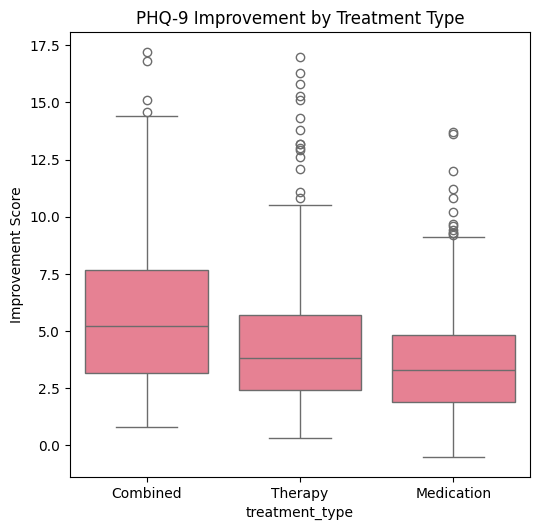

In [27]:
plt.figure(figsize=(15, 10))
#PHQ-9 improvement by treatment type
plt.subplot(2, 3, 1)
sns.boxplot(data=df, x='treatment_type', y='phq9_improvement')
plt.title('PHQ-9 Improvement by Treatment Type')
plt.ylabel('Improvement Score')
plt.tight_layout()
plt.show()

### Response rates by treatment type

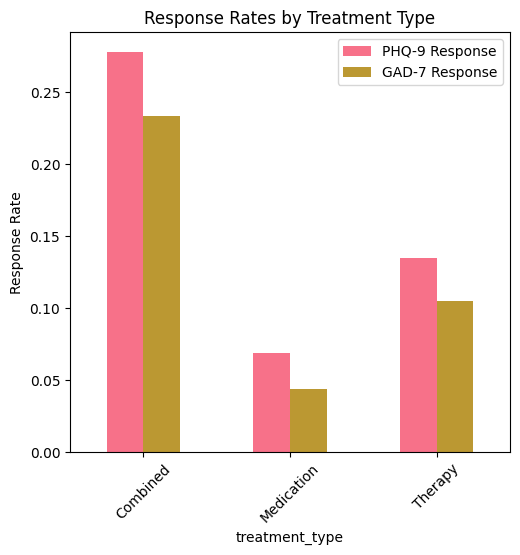

In [28]:
plt.figure(figsize=(15, 10))

plt.subplot(2, 3, 2)
response_data = df.groupby('treatment_type')[['phq9_response', 'gad7_response']].mean()
response_data.plot(kind='bar', ax=plt.gca())
plt.title('Response Rates by Treatment Type')
plt.ylabel('Response Rate')
plt.legend(['PHQ-9 Response', 'GAD-7 Response'])
plt.xticks(rotation=45)

plt.tight_layout()
plt.show()

### Treatment completion rates

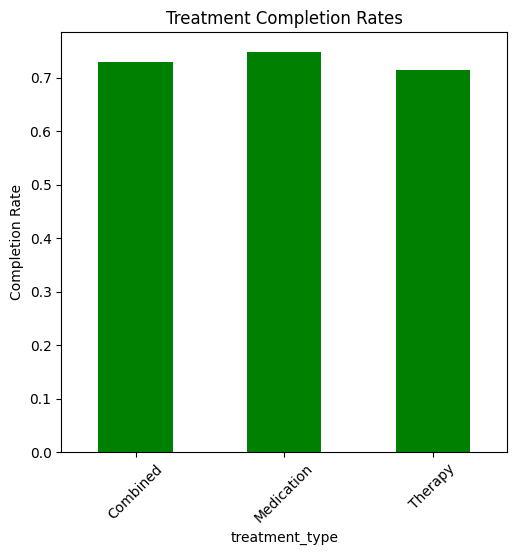

In [29]:
plt.figure(figsize=(15, 10))

plt.subplot(2, 3, 3)
completion_rates = df.groupby('treatment_type')['treatment_completed'].mean()
completion_rates.plot(kind='bar', color='green', ax=plt.gca())
plt.title('Treatment Completion Rates')
plt.ylabel('Completion Rate')
plt.xticks(rotation=45)

plt.tight_layout()
plt.show()

### Age distribution

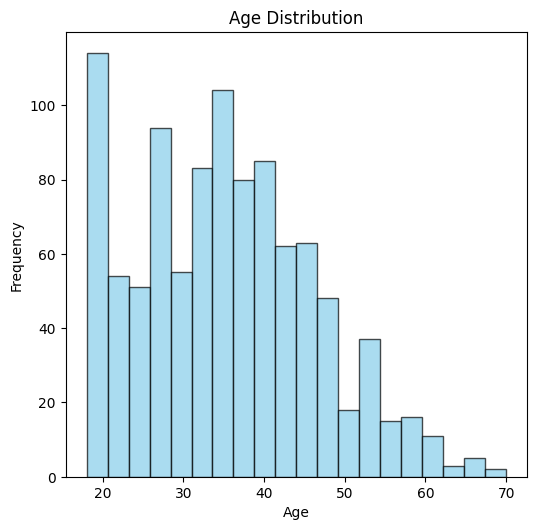

In [30]:
plt.figure(figsize=(15, 10))

plt.subplot(2, 3, 4)
plt.hist(df['age'], bins=20, alpha=0.7, color='skyblue', edgecolor='black')
plt.title('Age Distribution')
plt.xlabel('Age')
plt.ylabel('Frequency')
plt.tight_layout()
plt.show()

### Baseline vs Follow-up PHQ-9

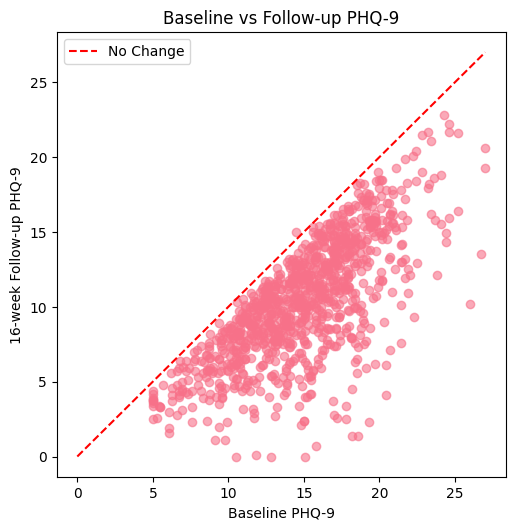

In [31]:
plt.figure(figsize=(15, 10))

plt.subplot(2, 3, 5)
plt.scatter(df['baseline_phq9'], df['followup_16w_phq9'], alpha=0.6)
plt.plot([0, 27], [0, 27], 'r--', label='No Change')
plt.xlabel('Baseline PHQ-9')
plt.ylabel('16-week Follow-up PHQ-9')
plt.title('Baseline vs Follow-up PHQ-9')
plt.legend()
plt.tight_layout()
plt.show()


###  Social support impact

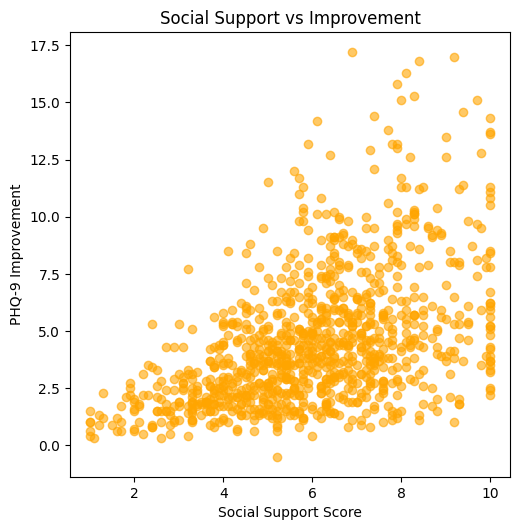

In [32]:
plt.figure(figsize=(15, 10))

plt.subplot(2, 3, 6)
plt.scatter(df['social_support_score'], df['phq9_improvement'], alpha=0.6, color='orange')
plt.xlabel('Social Support Score')
plt.ylabel('PHQ-9 Improvement')
plt.title('Social Support vs Improvement')

plt.tight_layout()
plt.show()

## Statistical Testing

In [33]:
# ANOVA for treatment effectiveness
print("ANOVA: Treatment Type vs PHQ-9 Improvement")
model = ols('phq9_improvement ~ C(treatment_type)', data=df).fit()
anova_results = sm.stats.anova_lm(model, typ=2)
print(anova_results)

print("\n Pairwise T-tests for PHQ-9 Improvement:")
treatment_groups = df['treatment_type'].unique()
for i, group1 in enumerate(treatment_groups):
    for group2 in treatment_groups[i+1:]:
        data1 = df[df['treatment_type'] == group1]['phq9_improvement']
        data2 = df[df['treatment_type'] == group2]['phq9_improvement']
        t_stat, p_value = ttest_ind(data1, data2)
        print(f"{group1} vs {group2}: t={t_stat:.3f}, p={p_value:.3f}")

ANOVA: Treatment Type vs PHQ-9 Improvement
                        sum_sq     df          F        PR(>F)
C(treatment_type)   583.610653    2.0  35.862682  9.115436e-16
Residual           8112.330057  997.0        NaN           NaN

 Pairwise T-tests for PHQ-9 Improvement:
Combined vs Therapy: t=4.954, p=0.000
Combined vs Medication: t=8.589, p=0.000
Therapy vs Medication: t=4.013, p=0.000


##  Correlation Analysis

In [34]:
# Select numeric variables for correlation
numeric_vars = ['age', 'baseline_phq9', 'baseline_gad7', 'treatment_duration_weeks', 
                'social_support_score', 'phq9_improvement', 'gad7_improvement']

correlation_matrix = df[numeric_vars].corr()
print(" Correlation Matrix:")
print(correlation_matrix.round(3))

 Correlation Matrix:
                            age  baseline_phq9  baseline_gad7  \
age                       1.000         -0.046         -0.054   
baseline_phq9            -0.046          1.000         -0.049   
baseline_gad7            -0.054         -0.049          1.000   
treatment_duration_weeks -0.065         -0.066          0.021   
social_support_score      0.022         -0.044         -0.052   
phq9_improvement         -0.064          0.358         -0.031   
gad7_improvement         -0.062         -0.076          0.385   

                          treatment_duration_weeks  social_support_score  \
age                                         -0.065                 0.022   
baseline_phq9                               -0.066                -0.044   
baseline_gad7                                0.021                -0.052   
treatment_duration_weeks                     1.000                 0.036   
social_support_score                         0.036                 1.000   
ph

### Visualize correlation matrix

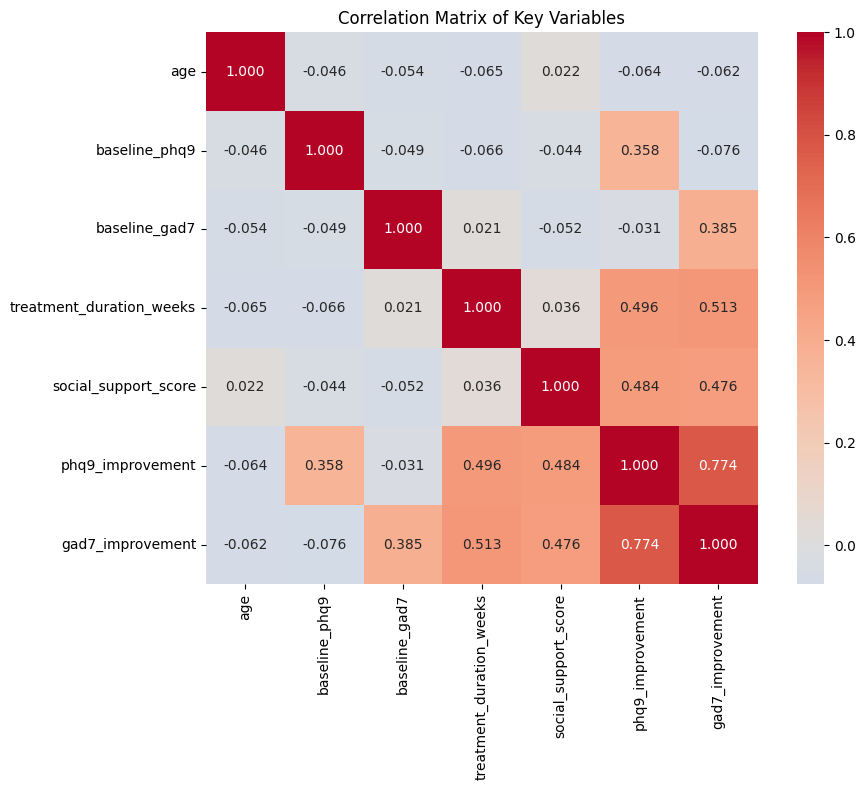

In [35]:
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', center=0,
            square=True, fmt='.3f')
plt.title('Correlation Matrix of Key Variables')
plt.tight_layout()
plt.show()

## Predictive Modeling Preparation

In [36]:
# Prepare features for modeling
features = ['age', 'baseline_phq9', 'baseline_gad7', 'treatment_duration_weeks', 
           'social_support_score']

# Encode categorical variables
le_gender = LabelEncoder()
le_treatment = LabelEncoder()
le_income = LabelEncoder()

df['gender_encoded'] = le_gender.fit_transform(df['gender'])
df['treatment_encoded'] = le_treatment.fit_transform(df['treatment_type'])
df['income_encoded'] = le_income.fit_transform(df['income_level'])

features.extend(['gender_encoded', 'treatment_encoded', 'income_encoded'])

X = df[features]
y_response = df['phq9_response'].astype(int)
y_improvement = df['phq9_improvement']

print(f"Features prepared for modeling: {len(features)} features")
print(f"Feature names: {features}")

Features prepared for modeling: 8 features
Feature names: ['age', 'baseline_phq9', 'baseline_gad7', 'treatment_duration_weeks', 'social_support_score', 'gender_encoded', 'treatment_encoded', 'income_encoded']


#  Machine Learning - Treatment Response Prediction

In [37]:
# Split data
X_train, X_test, y_train, y_test = train_test_split(X, y_response, test_size=0.2, random_state=42)

# Train Random Forest Classifier
rf_classifier = RandomForestClassifier(n_estimators=100, random_state=42)
rf_classifier.fit(X_train, y_train)

# Make predictions
y_pred = rf_classifier.predict(X_test)
y_pred_proba = rf_classifier.predict_proba(X_test)[:, 1]

# Evaluate model
accuracy = rf_classifier.score(X_test, y_test)
auc_score = roc_auc_score(y_test, y_pred_proba)

print(f"Treatment Response Prediction Model")
print(f"Accuracy: {accuracy:.3f}")
print(f"AUC Score: {auc_score:.3f}")

print("\nClassification Report:")
print(classification_report(y_test, y_pred))

Treatment Response Prediction Model
Accuracy: 0.895
AUC Score: 0.917

Classification Report:
              precision    recall  f1-score   support

           0       0.90      0.98      0.94       173
           1       0.75      0.33      0.46        27

    accuracy                           0.90       200
   macro avg       0.83      0.66      0.70       200
weighted avg       0.88      0.90      0.88       200

